In [1]:
## Working Notebook to add confeernce affilation to game data table

# Dependencies

import pandas as pd
import re
import numpy as np
import ast
import matplotlib.pyplot as plt
# import sns
import seaborn as sns

# Load Data
conference_df = pd.read_csv('../data/yearly_conference_members.csv')
games_df = pd.read_csv('../data/cfb_scores_all_years.csv')

# rename Unnamed: 0 to year in conference_df
conference_df = conference_df.rename(columns={'Unnamed: 0': 'Year'})



# Convert string representations of lists back into actual lists
for col in conference_df.columns[1:]:
    conference_df[col] = conference_df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


c:\Users\Justin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Justin\AppData\Local\Temp\ipykernel_5244\331398202.py:15: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  games_df = pd.read_csv('../data/cfb_scores_all_years.csv')


In [2]:
# conference_df.sample(5)

In [3]:
# Function to retrieve the conference based on year and team name
def get_conference_adjusted(year, team_name, conference_lookup):
    """
    Given a year and team name, retrieve the conference the team belongs to.
    If no conference found, return "Independent/Unknown".
    """
    return conference_lookup.get((year, team_name), "Independent/Unknown")

# Create a lookup dictionary for team-year to conference mapping
conference_lookup = {}

for _, row in conference_df.iterrows():
    year = row['Year']
    for col, teams in row[1:].items():
        for team in teams:
            conference_lookup[(year, team)] = col

# Use the adjusted function to assign conference for Winner and Loser
games_df['winner_conference'] = games_df.apply(lambda row: get_conference_adjusted(row['Year'], row['Winner'], conference_lookup), axis=1)
games_df['loser_conference'] = games_df.apply(lambda row: get_conference_adjusted(row['Year'], row['Loser'], conference_lookup), axis=1)

# Classify games as Regular Season or Post Season based on Date
games_df['Date'] = pd.to_datetime(games_df['Date'], errors='coerce')  # Convert the Date column to datetime format
games_df['season_type'] = games_df.apply(lambda row: "Post Season" if (row['Date'].month == 12 and row['Date'].day > 15) or row['Date'].month == 1 else "Regular Season", axis=1)


In [4]:
# games_df.info()

# value counts for winner and loser conference
games_df['winner_conference'].value_counts()
games_df['loser_conference'].value_counts()

# OUTPUT CSV TO TEMP FOLDER
# games_df.to_csv('../TEMP/ADJUSTED_cfb_scores_all_years.csv', index=False)

# Load The FBS Teams Table
fbs_teams_df = pd.read_csv('..\data\cfb_d1_teams_with_coordinates.csv')

In [5]:
games_df.head()
games_df.columns

Index(['Rk', 'Wk', 'Date', 'Day', 'Winner', 'Pts', 'Unnamed: 6', 'Loser',
       'Pts.1', 'Notes', 'Year', 'Time', 'Unnamed: 7', 'Winner_Ranking',
       'Loser_Ranking', 'winner_conference', 'loser_conference',
       'season_type'],
      dtype='object')

In [6]:
adjusted_games_df = games_df

# Extract the list of top division teams
d1_teams_list = fbs_teams_df['Team'].tolist()

# Filter the historical game data to only include games involving these teams
filtered_games_df = adjusted_games_df[(adjusted_games_df['Winner'].isin(d1_teams_list)) | (adjusted_games_df['Loser'].isin(d1_teams_list))]

# Display basic information and a sample of rows from the filtered dataframe
filtered_games_info = filtered_games_df.info()
filtered_games_sample = filtered_games_df.sample(30)

# filtered_games_info, filtered_games_sample


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65508 entries, 0 to 81603
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Rk                 65508 non-null  int64         
 1   Wk                 65508 non-null  int64         
 2   Date               65508 non-null  datetime64[ns]
 3   Day                65508 non-null  object        
 4   Winner             65508 non-null  object        
 5   Pts                65507 non-null  float64       
 6   Unnamed: 6         24057 non-null  object        
 7   Loser              65508 non-null  object        
 8   Pts.1              65507 non-null  float64       
 9   Notes              4966 non-null   object        
 10  Year               65508 non-null  int64         
 11  Time               7080 non-null   object        
 12  Unnamed: 7         3440 non-null   object        
 13  Winner_Ranking     0 non-null      float64       
 14  Loser_

In [7]:
# Adjust the conference lookup to assign "Independent/Unknown" for missing teams
def get_conference_adjusted(year, team_name, conference_lookup):
    """
    Given a year and team name, retrieve the conference the team belongs to.
    If no conference found, return "Independent/Unknown".
    """
    return conference_lookup.get((year, team_name), "Independent/Unknown")

# Rename df to games_df_new
games_df_new = games_df

# Use the adjusted function to assign conference for Winner and Loser
games_df_new['winner_conference'] = games_df_new.apply(lambda row: get_conference_adjusted(row['Year'], row['Winner'], conference_lookup), axis=1)
games_df_new['loser_conference'] = games_df_new.apply(lambda row: get_conference_adjusted(row['Year'], row['Loser'], conference_lookup), axis=1)

# Classify games as Regular Season or Post Season based on Date
games_df_new['Date'] = pd.to_datetime(games_df_new['Date'], errors='coerce')  # Convert the Date column to datetime format
games_df_new['season_type'] = games_df_new.apply(lambda row: "Post Season" if (row['Date'].month == 12 and row['Date'].day > 15) or row['Date'].month == 1 else "Regular Season", axis=1)



# Classify games as Conference or Non-Conference - Teams in the same conference are considered conference games - Indepentent teams are allway considered non-conference games
games_df_new['game_type'] = games_df_new.apply(lambda row: "Conference" if row['winner_conference'] == row['loser_conference'] else "Non-Conference", axis=1)

# If either team is Independent, the game is considered Non-Conference
games_df_new.loc[games_df_new['winner_conference'] == "Independent/Unknown", 'game_type'] = "Non-Conference"
games_df_new.loc[games_df_new['loser_conference'] == "Independent/Unknown", 'game_type'] = "Non-Conference"


# Display the updated dataframe with the new columns
# games_df_new.sample(30)



In [8]:
## Show breakdown of games by season type and game type
games_df_new.groupby(['season_type', 'game_type']).size()


season_type     game_type     
Post Season     Conference           34
                Non-Conference     1614
Regular Season  Conference        19600
                Non-Conference    60356
dtype: int64

In [9]:
## Extract Notes for Bowl Game and Champ Game Names

# Value COunts
games_df_new['Notes'].value_counts().head(20)

# If notes contains Bowl, then copy the notes to the bowl_game column
games_df_new['bowl_game'] = games_df_new.apply(lambda row: row['Notes'] if isinstance(row['Notes'], str) and 'Bowl' in row['Notes'] else None, axis=1)
# Clear the Bowl Cells from the Notes Column
games_df_new['Notes'] = games_df_new.apply(lambda row: None if isinstance(row['Notes'], str) and 'Bowl' in row['Notes'] else row['Notes'], axis=1)




# value counts for bowl_game
games_df_new['bowl_game'].value_counts()
# Notes value count
games_df_new['Notes'].value_counts()

# Save new Csv to data folder as game_info_v2
# games_df_new.to_csv('../data/game_info_v2.csv', index=False)


Lincoln Financial Field - Philadelphia, Pennsylvania    30
Neyland Stadium - Knoxville, Tennessee                  29
Beaver Stadium - University Park, Pennsylvania          28
Michigan Stadium - Ann Arbor, Michigan                  28
Raymond James Stadium - Tampa, Florida                  28
                                                        ..
NRG Stadium - Houston Texas                              1
LP Field - Nashville Tennessee                           1
Cancelled due to weather                                 1
Georgia Dome - Atlanta Georgia                           1
College Football Playoff National Championship           1
Name: Notes, Length: 309, dtype: int64

In [10]:
## Transform to parse notes column for game sites, names, ect

def transform_game_info(df):
    # Determine Home and Away Teams
    def determine_home_away(row):
        if row['Unnamed: 6'] == "@":
            return row['Loser'], row['Winner'], row['Pts.1'], row['Pts']
        else:
            return row['Winner'], row['Loser'], row['Pts'], row['Pts.1']

    df['HostTeamName'], df['AwayTeamName'], df['HostScore'], df['AwayScore'] = zip(*df.apply(determine_home_away, axis=1))
    
    # Identify Neutral Site Games
    def is_neutral_site(row):
        # All postseason games are at neutral sites
        if row['season_type'] == 'Post Season':
            return True
        # Handle special event names in the 'Notes' column
        keywords = ["Championship", "Classic", "Festival", "Cup", "Bowl"]
        if pd.notnull(row['Notes']) and any(keyword in row['Notes'] for keyword in keywords):
            return True
        return False

    df['IsNeutralSite'] = df.apply(is_neutral_site, axis=1)
    
    # Handle games mentioning a specific location or stadium
    stadium_note_games = df[df['Notes'].str.contains("Stadium|Field|Park|Arena|Dome", na=False)]
    common_stadiums = stadium_note_games.groupby(['Notes', 'HostTeamName']).size().reset_index(name='counts')
    non_neutral_stadiums = common_stadiums[common_stadiums['counts'] > 2]['Notes'].tolist()
    df.loc[df['Notes'].isin(non_neutral_stadiums), 'IsNeutralSite'] = False
    
    # Save special event names in the bowl_game column if it's empty
    def update_bowl_game(row):
        if pd.isnull(row['bowl_game']):
            keywords = ["Championship", "Classic", "Festival", "Cup", "Bowl"]
            if pd.notnull(row['Notes']) and any(keyword in row['Notes'] for keyword in keywords):
                return row['Notes']
        return row['bowl_game']

    df['bowl_game'] = df.apply(update_bowl_game, axis=1)
    
    return df

# Load the game_info_v2 CSV file and apply the transformation

transformed_game_info_new = transform_game_info(games_df_new)

# Display the first few rows of the transformed data
transformed_game_info_new_head = transformed_game_info_new.head()
transformed_game_info_new_head



,Rk,Wk,Date,Day,Winner,Pts,Unnamed: 6,Loser,Pts.1,Notes,...,winner_conference,loser_conference,season_type,game_type,bowl_game,HostTeamName,AwayTeamName,HostScore,AwayScore,IsNeutralSite
0,1,1,1869-11-06,Sat,Rutgers,6.0,NaN,Princeton,4.0,NaN,...,Independent/Unknown,Independent/Unknown,Regular Season,Non-Conference,None,Rutgers,Princeton,6.0,4.0,False
1,2,2,1869-11-13,Sat,Princeton,8.0,NaN,Rutgers,0.0,NaN,...,Independent/Unknown,Independent/Unknown,Regular Season,Non-Conference,None,Princeton,Rutgers,8.0,0.0,False
2,1,1,1870-11-05,Sat,Rutgers,6.0,NaN,Columbia,3.0,NaN,...,Independent/Unknown,Independent/Unknown,Regular Season,Non-Conference,None,Rutgers,Columbia,6.0,3.0,False
3,2,2,1870-11-12,Sat,Princeton,6.0,NaN,Rutgers,2.0,NaN,...,Independent/Unknown,Independent/Unknown,Regular Season,Non-Conference,None,Princeton,Rutgers,6.0,2.0,False
4,1,1,1872-11-02,Sat,Rutgers,0.0,@,Columbia,0.0,NaN,...,Independent/Unknown,Independent/Unknown,Regular Season,Non-Conference,None,Columbia,Rutgers,0.0,0.0,False


In [11]:
transformed_game_info_new_head.columns

Index(['Rk', 'Wk', 'Date', 'Day', 'Winner', 'Pts', 'Unnamed: 6', 'Loser',
       'Pts.1', 'Notes', 'Year', 'Time', 'Unnamed: 7', 'Winner_Ranking',
       'Loser_Ranking', 'winner_conference', 'loser_conference', 'season_type',
       'game_type', 'bowl_game', 'HostTeamName', 'AwayTeamName', 'HostScore',
       'AwayScore', 'IsNeutralSite'],
      dtype='object')

In [12]:
# Rename columns for clairity
cols = ['season_index','week','date','day','winner','winner_pt','loc_ind','loser','loser_pt','location','season_year','time','loc_ind2',
        'winner_ranking','loser_ranking','winner_conf','loser_conf',
        'season_type',
       'game_type', 'bowl_game', 'HostTeamName', 'AwayTeamName', 'HostScore',
       'AwayScore', 'IsNeutralSite']

transformed_game_info_new.columns = cols

In [13]:
# ## value counts for bowl_game
# transformed_game_info_new['bowl_game'].value_counts()

# # notes value count
# transformed_game_info_new['Notes'].value_counts()

# rename transformed_game_info to games_df_new
games_df_new = transformed_game_info_new

# Save new Csv to data folder as game_info_v3
games_df_new.to_csv('../data/game_info_v3.csv', index=False)

In [14]:
# Add a coulmn with the Margin of Victory
# games_df_new['margin'] = games_df_new['Winner_Pts'] - games_df_new['Loser_Pts']

In [15]:
# save csv to data folder as game_info_v2
games_df_new.to_csv('../data/cfb_game_data_expanded.csv', index=False)

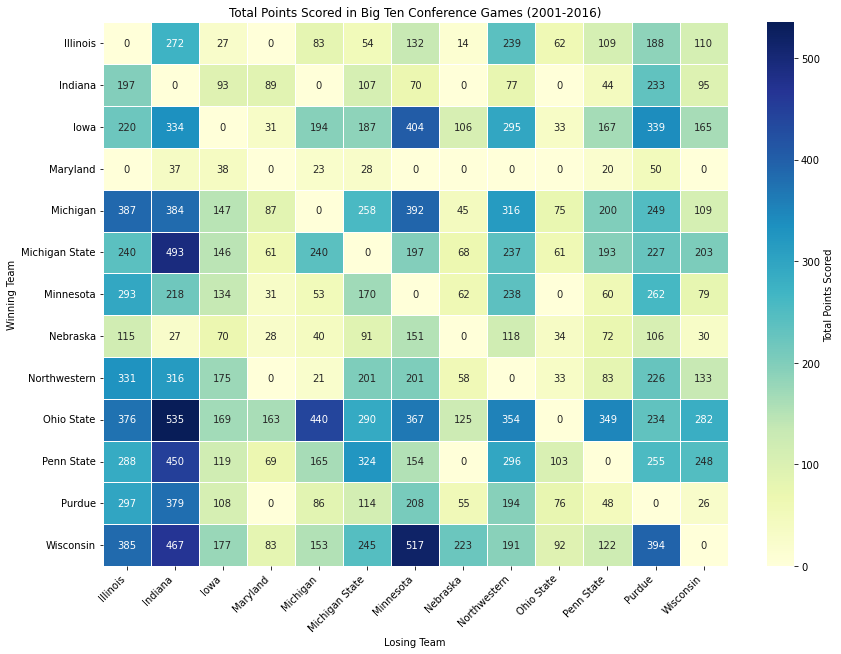

In [22]:
game_data = games_df_new

# Filter data to only include games from 2011-2016, within the Big Ten Conference, and that are conference games
big_ten_data = game_data[(game_data['season_year'].between(2001, 2016)) & 
                         (game_data['winner_conf'] == 'Big Ten Conference') &
                          (game_data['loser_conf'] == 'Big Ten Conference') & 
                         (game_data['game_type'] == 'Conference')]

# Group by winner and loser to get sum of points scored
points_scored_big_ten = big_ten_data.groupby(['winner', 'loser']).agg({'winner_pt': 'sum'}).reset_index()

def plot_big_ten_heatmap(data):
    # Pivot the data for the heatmap
    heatmap_data = data.pivot('winner', 'loser', 'winner_pt')
    # Fill NaN with 0 and remove rows and columns that have only zeros
    heatmap_data = heatmap_data.fillna(0)
    heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1) > 0, heatmap_data.sum(axis=0) > 0]
    
    if heatmap_data.empty:
        print("No sufficient data available for the heatmap.")
        return
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".0f", cbar_kws={'label': 'Total Points Scored'})
    plt.title('Total Points Scored in Big Ten Conference Games (2001-2016)')
    plt.ylabel('Winning Team')
    plt.xlabel('Losing Team')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

# Plot the heatmap for Big Ten Conference games from 2011-2016
plot_big_ten_heatmap(points_scored_big_ten)


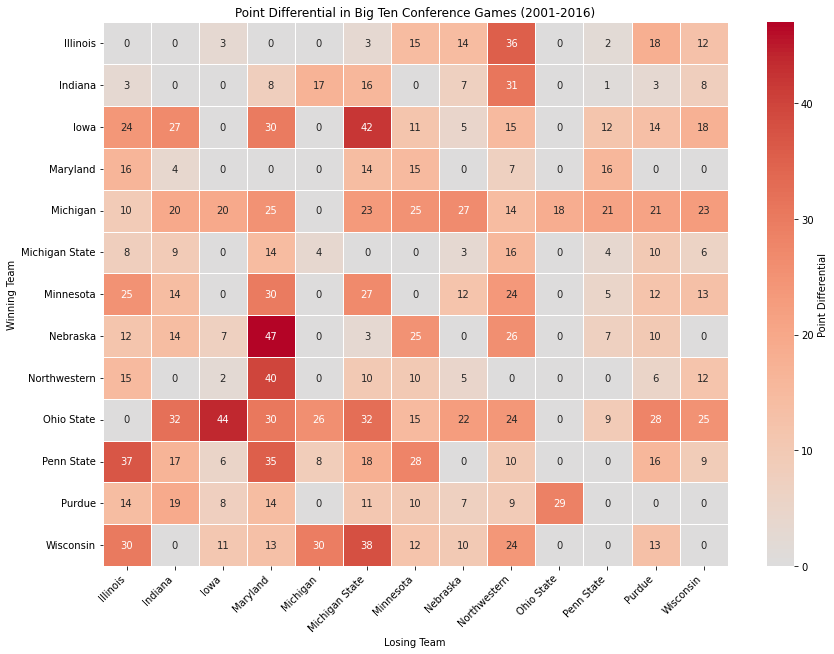

In [25]:

# Filter data to only include games from 2011-2016, within the Big Ten Conference, and that are conference games
big_ten_data = game_data[(game_data['season_year'].between(2018, 2023)) & 
                         (game_data['winner_conf'] == 'Big Ten Conference') &
                          (game_data['loser_conf'] == 'Big Ten Conference') & 
                         (game_data['game_type'] == 'Conference')]

big_ten_data_diff = big_ten_data.copy()
# Compute point differential for each game
big_ten_data_diff['point_diff'] = big_ten_data_diff['winner_pt'] - big_ten_data_diff['loser_pt']

# Group by winner and loser to get sum of point differentials
point_diff_big_ten = big_ten_data_diff.groupby(['winner', 'loser']).agg({'point_diff': 'mean'}).reset_index()

def plot_big_ten_diff_heatmap(data):
    # Pivot the data for the heatmap
    heatmap_data = data.pivot('winner', 'loser', 'point_diff')
    # Fill NaN with 0 and remove rows and columns that have only zeros
    heatmap_data = heatmap_data.fillna(0)
    heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1) > 0, heatmap_data.sum(axis=0) > 0]
    
    if heatmap_data.empty:
        print("No sufficient data available for the heatmap.")
        return
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(heatmap_data, cmap="coolwarm", center=0, linewidths=.5, annot=True, fmt=".0f", cbar_kws={'label': 'Point Differential'})
    plt.title('Point Differential in Big Ten Conference Games (2001-2016)')
    plt.ylabel('Winning Team')
    plt.xlabel('Losing Team')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

# Plot the heatmap for Big Ten Conference games from 2001-2016
plot_big_ten_diff_heatmap(point_diff_big_ten)
